# Image Reconstruction in a Nutshell - with BART

## PhD-Training of DS-ISMRM in Ulm

- 17. & 18. March 2025

The purpose of this notebook is to introduce basic concepts of the [BART toolbox](https://mrirecon.github.io/bart), and its use as a tool for reconstruction.

We recommend checking other points of reference, primarily available in the following locations:
- [BART Workshops](https://github.com/mrirecon/bart-workshop)
- [BART Webinars](https://github.com/mrirecon/bart-webinars) (and [webinar recordings](https://www.youtube.com/@bart-toolboxdepartmental7435/playlists)\)

## On the Idea of this Notebook

Many tutorials on BART are provided as Jupyter notebooks. The reason behind this is that Jupyter Notebooks are a great tool to combine code and markdown text in a single document, share them with others, and run them on online hosted services like Google Colab. It should be mentioned that most users of BART don't use Jupyter Notebooks, but rather write scripts to write their reconstruction pipelines.

In this interactive session, we recommend running BART calls in the terminal, and use this notebook as a reference. Nevertheless, we will provide some examples of how to run BART commands in this notebook to be self-contained.

**💡Hint:💡**

- **`%%bash` Cells in Jupyter Notebooks:**
  In Google Colab, `%%bash` cells allow you to run bash commands directly within your notebook.
  Simply prefix your cell with `%%bash`, and you can run any shell command, including calls to BART tools, just as you would in a terminal.
  If you only have a single command you can also prefix it with `!` for the same effect.

## Content

* BART Fundamentals
  * BART Command Structure
  * File Formats and Metadata
  * Python Bindings
  * Look at Everything (`bart view`)
* An Image Reconstruction Pipeline in BART
  * Downloading Data
  * Reconstruction of Fully-Sampled Data
  * Undersampling
  * Coil Compression
  * Coil Sensitivity Estimation
  * Reconstruction with PICS
* Various Aspects (if time allows)
  * NLINV for Joint Estimation of Coils and Image
  * Removing Frequency Oversampling

## Installation

You can find more information on BART on the [Website](https://mrirecon.github.io/bart/).

## Setup

As a first step, you should check where BART is installed on your system and which version you are using:

In [1]:
%%bash

echo "# BART location: "
which bart

echo "# BART version: "
bart version

# BART location: 
/home/mblum/Bart/bart/bart
# BART version: 
v0.9.00-755-ga902642


## BART Fundamentals
BART provides a number of tools for MR image reconstruction and multi-dimensional array manipulation. We can get a list of them by running `bart` with no arguments.

Note: The ! character indicates that the following cell should be executed in bash vs. the native python kernel. It is not necessary when running BART commands from your terminal.



In [2]:
# get a list of BART commands by running bart with no arguments:
! bart

BART. Available commands are:
affinereg   avg         bench       bin         bitmask     cabs        
calc        caldir      calmat      carg        casorati    cc          
ccapply     cdf97       circshift   conj        conv        conway      
copy        cpyphs      creal       crop        delta       denoise     
ecalib      ecaltwo     epg         estdelay    estdims     estmotion   
estshift    estvar      extract     fakeksp     fft         fftmod      
fftrot      fftshift    filter      flatten     flip        fmac        
fovshift    grog        homodyne    ictv        index       interpolate 
invert      itsense     join        looklocker  lrmatrix    mandelbrot  
measure     mip         mnist       moba        mobafit     morphop     
multicfl    ncalib      nlinv       nlinvnet    nlmeans     nnet        
noise       normalize   nrmse       nufft       nufftbase   onehotenc   
ones        pattern     phantom     pics        pocsense    poisson     
pol2mask    poly     

### BART Command Structure

All BART commands are structured in the following way:

> **`bart`** + **`command`** + **`options`** + **`input / output`**

Each BART command consists of a number of optional arguments, followed by input and output files. To get some information about a command, use the **-h** flag. Optional arguments are indicated by brackets, and files are indicated by `<,>` symbols.

For example, the following command demonstrates the full suite of options for generating a numerical phantom in the image or k-space domain:

In [3]:
! bart phantom -h

Usage: phantom [-s d] [-S d] [-k] [-t <file>] [-G] [-T] [--NIST] [--SONAR] [--BRAIN] [--ELLIPSOID] [--ellipsoid_center d:d:d] [--ellipsoid_axes f:f:f] [-N d] [-B] [--FILE <file>] [-x d] [-g d] [-3] [-b] [-r d] [--rotation-angle f] [--rotation-steps d] [--coil ...] <output> 

Image and k-space domain phantoms.

-s nc                       nc sensitivities
-S nc                       Output nc sensitivities
-k                          k-space
-t file                     trajectory
-G                          geometric object phantom
-T                          tubes phantom
--NIST                      NIST phantom (T2 sphere)
--SONAR                     Diagnostic Sonar phantom
--BRAIN                     BRAIN geometry phantom
--ELLIPSOID                 Ellipsoid.
--ellipsoid_center d:d:d    x,y,z center coordinates of ellipsoid.
--ellipsoid_axes f:f:f      Axes lengths of ellipsoid.
-N num                      Random tubes phantom with num tubes
-B                          BART logo
-

The `phantom` tool includes the option `-k` to create it in k-space, and `-x` to specify the size. Let's generate a 2D phantom in image space:

In [4]:
! bart phantom phantom

### File formats and metadata

The phantom image "*phantom*" is stored in a BART-specific file format in your current working directory. If you open the directory, you will see two files: `phantom.cfl` and `phantom.hdr`. These files contain the raw data and metadata, respectively.

BART data files are (typically) stored in two files:

* A header (`.hdr`) file which contains metadata (dimensions, file type, etc.)

* A complex float (`.cfl`) file which contains the raw data.

The header file can be opened and read as a normal text file, while the raw data is a binary file. The raw data is a multi-dimensional array of single-precision complex floats, stored in col-major order with interleaved real and imaginary components.

Open the header file to see the metadata, you can use any text editor or the `cat` command in the terminal:


In [5]:
! cat phantom.hdr

# Dimensions
128 128 1 1 1 1 1 1 1 1 1 1 1 1 1 1 
# Command
phantom phantom 
# Files
 >phantom
# Creator
BART v0.9.00-755-ga902642


As you can see, the header file contains information about the dimensions of the data which is in our case a 2D image of size 128x128. Generally, MRI data can be very high-dimensional, so BART is designed to handle multi-dimensional (up to 16-dimensional) data. If you are familiar with numpy, a 16 dimensional numpy array is the equivalent. However, in most applications, many dimensions are singleton, i.e. have size 1. For some tools (ecalib, pics, nlinv, ...), specific dimensions have a special meaning, so it is generally a good idea to stick to the default dimension order:

#### BART Data Format for Cartesian Data

For our Cartesian data, BART expects the following dimension order:

| Index | Dimension Name | Description |
|-------|----------------|-------------|
| 0     | READ_DIM       | Readout dimension |
| 1     | PHS1_DIM       | First phase-encoding dimension |
| 2     | PHS2_DIM       | Second phase-encoding dimension |
| 3     | COIL_DIM       | Receiver coil dimension |
| 4     | MAPS_DIM       | Maps dimension (e.g., for multiple sets of sensitivity maps) |
| 5     | TE_DIM         | Echo time dimension |
| 6     | COEFF_DIM      | Coefficient dimension (e.g., for parameter maps) |
| ...   | ...            | ... |
| 10    | TIME_DIM       | Dimension for time series |
| ...   | ...            | ... |

There is also a bart command to display the dimensions of a file, `show`:

In [6]:
! bart show -m phantom

Type: complex float
Dimensions: 16
AoD:	128	128	1	1	1	1	1	1	1	1	1	1	1	1	1	1


Note that the file extension is not required when using the BART commands.

### Python Bindings

BART comes equipped with Python bindings that easily integrate with popular scientific computing libraries in Python. The python bindings provide functions to read and write NumPy arrays as BART data files. Moreover, you can apply BART commands directly to NumPy arrays.


<details>
  <summary>If you are interested you can find a more detailed explanation of the Python bindings by expanding this cell.</summary>

If you're running in Colab, the paths should be updated and you should be all set to run the following demos.

If you are running locally, you will need to directly import the bart module. To do this, you can add BART's python directory to your `PYTHONPATH` environment variable. Add the following line to your .bashrc to do this:

```bash
export PYTHONPATH="${BART_TOOLBOX_PATH}/python:$PYTHONPATH"
```

Where `BART_TOOLBOX_PATH` is the location of your BART install.

This way, we can import the bart module as well as cfl, our utility file for dealing with BART's data format: a .hdr header file and a .cfl file of complex-float data.

If you're already running the demo in Colab, you may have to manually modify the path, which we do here:
</details>

In [7]:
%%bash

# we can use pip install to install the Python bindings using the package description in the pkg/python subdirectory
echo $BART_TOOLBOX_PATH
pip install $BART_TOOLBOX_PATH/pkg/python

/home/mblum/Bart/bart
Processing /home/mblum/Bart/bart/pkg/python
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for bart: filename=bart-0.9.0-py3-none-any.whl size=7318 sha256=77bb250d0dd8941457792aeb0c60b18a11e48a52bae40724d4167f93887edd5f
  Stored in directory: /tmp/pip-ephem-wheel-cache-kze2xlyd/wheels/b1/6c/e1/e76a30b8436030ee4d10aa23c8dae084a11860ed38e6cb610a
Successfully built bart
  Attempting uninstall: bart
    Found existing installation: bart 0.9.0
    Uninstalling bart-0.9.0:
      Successfully uninstalled bart-0.9.0


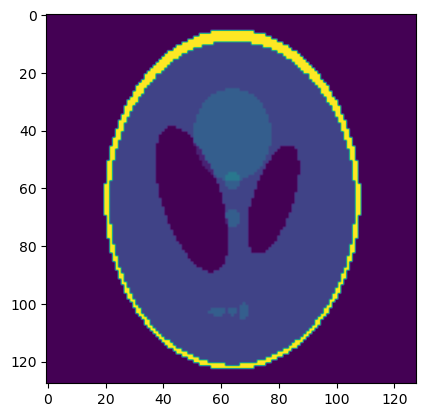

In [8]:
#This is now a python cell

import cfl
phan = cfl.readcfl('phantom')

from matplotlib import pyplot as plt
plt.imshow(phan.real)
plt.show()

### Look at Everything

Obviously a golden rule of image reconstruction (and science in general) is to always look at your data and intermediate results. Does your data make sense? Do your dimensions make sense? Do your coil sensitivities make sense? Do your reconstructions make sense? Always look at your data!

The **view** tool is a simple way to visualize image data. It does not directly come with a BART installation but can be installed on Debian-based systems with 'apt install bart-view' or can be installed following the instructions at [GitHub](https://github.com/mrirecon/view). Alternatively, you could load the data into Python/Matlab and view it there.

Let's view the phantom image we generated earlier:


In [9]:
!bart view phantom

## An Image Reconstruction Pipeline in BART

### Download Data

For this tutorial, we use a fully-sampled Cartesian brain dataset available at [Zenodo](https://zenodo.org/record/14497769). The dataset is already in the BART format. So you can investigate it with the `show` command or view it with the `view` command.

In [10]:
! wget https://zenodo.org/records/14497769/files/ksp_fully.hdr -O ksp_fully.hdr
! wget https://zenodo.org/records/14497769/files/ksp_fully.cfl -O ksp_fully.cfl

--2025-03-11 13:29:22--  https://zenodo.org/records/14497769/files/ksp_fully.hdr
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.43.25, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 144 [application/octet-stream]
Saving to: ‘ksp_fully.hdr’

ksp_fully.hdr       100%[===================>]     144  --.-KB/s    in 0.02s   

2025-03-11 13:29:23 (7.80 KB/s) - ‘ksp_fully.hdr’ saved [144/144]

--2025-03-11 13:29:23--  https://zenodo.org/records/14497769/files/ksp_fully.cfl
Resolving zenodo.org (zenodo.org)... 188.185.43.25, 188.185.45.92, 188.185.48.194, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68812800 (66M) [application/octet-stream]
Saving to: ‘ksp_fully.cfl’

ksp_fully.cfl       100%[===================>]  65.62M  2.66MB/s    in 25s     

2025-03-11 13:29:49 (2.60 MB/s) - ‘ksp_fully.cfl’ sav

In [11]:
!bart view ksp_fully

### Reconstruction of Fully-Sampled Data

As we have a fully-sampled dataset, we can directly use the inverse FFT to transform the k-space data to image space. Afterwards, separate coil images can be combined with the root-sum-of-squares (RSS) method. You will need to use the `bart fft` and `bart rss` commands for this task. Look at the help of both.

Here, we introduce the concept of `bitmask` in BART to select the dimensions along which the FFT is performed or along which the sum is taken. Each bit of the bitmask decides whether the corresponding dimension is selected or not. For example, if you want to select dimension 0 and 3, the bitmask would be $9 = 2^0 + 2^3$. The `bart bitmask` command can be used to generate the bitmask.

What is the bitmask for the inverse FFT? What is the bitmask for the RSS combination?


In [12]:
%%bash

bart fft -i 3 ksp_fully coil_image_fully
bart rss 8 coil_image_fully rss_fully

bart view coil_image_fully rss_fully

### Undersampling

We perform some retrospective undersampling of the data. You can generate a regular undersampling pattern using the `bart upat` command. As undersampling in read out direction never makes sense, the pattern will have undersampling in y and z direction by default. You need to specify dimensions for the undersampling pattern according to the k-space dimensions. You should also include some AC region by setting `-c12`.

After generating the undersampling pattern, you can multiply it with the k-space using the `bart fmac` (fused multiply-accumulate) command. Probably you want to do an inverse FFT and RSS reconstruction afterwards to see the effect on the image.

In [15]:
%%bash

bart upat -c12 -y3 -Y420 -Z1 pattern
bart fmac ksp_fully pattern ksp_us

bart view ksp_us

In [16]:
%%bash

bart fft -i 3 ksp_us coil_image_us
bart rss 8 coil_image_us rss_us

bart view rss_us

### Coil Compression

A standard approach to speed up iterative reconstructions is to compress the k-space data along the coil dimension. This can be done with the `bart cc` command. The command requires the number of singular values to keep which you can provide with the `-p` option. Use eight virtual coils for the compression.

If you want to investigate the effect of coil compression, perform coil compression on the fully sampled data, keep many coils, and look at the coil images after performing the inverse FFT. You'll see that later coils contain less information and mostly noise.


**💡Hint:💡**

- **Debug Level**
  By default the `bart cc` command does not print any output. You can increase the debug level by setting the `BART_DEBUG_LEVEL` environment variable to a higher debug level.


In [17]:
%%bash

export BART_DEBUG_LEVEL=4
bart cc -p10 ksp_us ksp_cc

bart view ksp_cc

Calibration region...  (size: 24x24x1, pos: 309x198x0)
Energy: 0.369 0.270 0.136 0.078 0.051 0.037 0.018 0.015 0.013 0.005 0.003 0.003 0.001 0.001 0.001 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
Compressing to 10 virtual coils...
Done.


In [18]:
%%bash

export BART_DEBUG_LEVEL=4
bart cc -p32 ksp_fully ksp_cc_fully
bart fft -i 3 ksp_cc_fully coil_images_cc_fully

bart view coil_images_cc_fully

Calibration region...  (size: 24x24x1, pos: 309x198x0)
Energy: 0.369 0.270 0.136 0.078 0.051 0.037 0.018 0.015 0.013 0.005 0.003 0.003 0.001 0.001 0.001 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
Compressing to 32 virtual coils...
Done.


### Coil Sensitivity Estimation

One option to estimate coil sensitivity maps from a fully sampled, Cartesian auto-calibration region is the ESPIRiT algorithm. The `bart ecalib` command can be used for this task. By default, the command estimates two sets of sensitivity maps (c.f. the paper for details). We only need one set, so you can select the first set with the `-m 1` option.

In [19]:
%%bash

export BART_DEBUG_LEVEL=4
bart ecalib -m1 ksp_cc coil

bart view coil

Calibration region...  (size: 24x24x1, pos: 309x198x0)
Energy: 0.372 0.273 0.137 0.079 0.052 0.037 0.018 0.015 0.013 0.005
Build calibration matrix and SVD...
Eigen decomposition... (size: 360)
Using 36/360 kernels (10.00%, last SV: 0.033626).
Zeropad...
FFT (juggling)...
Calculate Gram matrix...
Resize...
Point-wise eigen-decomposition...
Crop maps... (c = 0.80)
Fix phase...
Done.


### Reconstruction with PICS

Finally, we have all data available to use the Swiss Army knife of linear MR image reconstruction: the `bart pics` tool. You can use it without any regularization options to perform a SENSE reconstruction:

In [20]:
%%bash

export BART_DEBUG_LEVEL=4
bart pics ksp_cc coil recon

bart view recon

Size: 268800 Samples: 99839 Acc: 2.69
Calibration region...  (size: 32x24x1, pos: 302x198x0)
Scaling: 0.000282  (max = 0.000761/p90 = 0.000282/median = 0.000009)
Inverse scaling of the data: 0.000282
Regularization terms: 0, Supporting variables: 0
conjugate gradients
	 cg:  30
Total Time: 3.724850


Note that pics scales (normalizes) your data by default. You can turn this off by providing a scaling ´-w´ or undo the scaling ´-S´ afterwards.
We can now add some regularization (as we use regular undersampling pattern, we don't perform compressed sensing). You can use the `-Rh` option to print help on available regularization in pics. Most regularizations require two flags, 1.) which dimensions to perform a transform (e.g. Wavelet or gradients) over and a joint thresholding flag, which is in our case 0.

You can try Wavelet regularization and experiment with different strength -RW:3:0:0.01, -RW:3:0:0.1, -RW:3:0:1, etc. In a sweet spot, you will see that the noise is slightly reduced.

## Various Aspects (if time allows)

### NLINV for Joint Estimation of Coils and Image

The `bart nlinv` command can be used for joint estimation of coil sensitivities and the image, hence you only need to provide it the k-space data. We will discuss and use the command in the next sessions, but you can try it here already:

In [3]:
%%bash

export BART_DEBUG_LEVEL=4
bart nlinv ksp_cc recon_nlinv coil_nlinv

bart view recon_nlinv coil_nlinv


Model created (Cartesian):
kspace:  [640 420   1   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
images:  [640 420   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
coils:   [640 420   1   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
pattern: [640 420   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
coilimg: [640 420   1   8   1   1   1   1   1   1   1   1   1   1   1   1 ]

Scaling: 1228.981934
Step: 0, Res: 100.000002
	 cg:   1
Step: 1, Res: 99.993176
	 cg:   0
Step: 2, Res: 99.632359
	 cg:   1
Step: 3, Res: 98.893138
	 cg:   2
Step: 4, Res: 92.974706
	 cg:   3
Step: 5, Res: 73.474311
	 cg:   4
Step: 6, Res: 50.115916
	 cg:   2
Step: 7, Res: 8.538334
	 cg:  11
Total time: 15.40 s


### Removing Frequency Oversampling

To remove frequency oversampling, you need to perform an inverse FFT along the readout direction, crop the data, and perform a forward FFT again. For cropping, you can use the `bart resize` command with the `-c` option. The center cropping of resize is consistent with the definition of the center of the FFT.
The NLINV reconstruction will be faster now:)

In [5]:
%%bash

export BART_DEBUG_LEVEL=4
bart fft -u -i 1 ksp_cc tmp
bart resize -c 0 320 tmp tmp
bart fft -u 1 tmp ksp_no_os

bart nlinv ksp_no_os recon_nlinv_no_os coil_nlinv_no_os

bart view recon_nlinv_no_os coil_nlinv_no_os


Model created (Cartesian):
kspace:  [320 420   1   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
images:  [320 420   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
coils:   [320 420   1   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
pattern: [320 420   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
coilimg: [320 420   1   8   1   1   1   1   1   1   1   1   1   1   1   1 ]

Scaling: 1229.449707
Step: 0, Res: 100.000010
	 cg:   1
Step: 1, Res: 99.986287
	 cg:   0
Step: 2, Res: 99.626723
	 cg:   1
Step: 3, Res: 98.877515
	 cg:   2
Step: 4, Res: 92.907263
	 cg:   3
Step: 5, Res: 73.338651
	 cg:   4
Step: 6, Res: 49.953508
	 cg:   2
Step: 7, Res: 8.081363
	 cg:  11
Total time: 8.13 s
